In [1]:
import os
import pandas as pd 
import numpy as np

In [2]:
# df = pd.read_csv("Amazon_data - Sheet1.csv")
df = pd.read_csv("train_with_image_name_all_test.csv")

In [3]:
df['downloaded_image_name'].value_counts()

downloaded_image_name
51m1gdQJW2L.jpg    45
NAN                15
71brV+lqbRL.jpg    15
71LRdXdqc0L.jpg    11
51DDKoa+mbL.jpg     9
                   ..
81w6SwBLYlL.jpg     1
61gQnQDp52L.jpg     1
71gis4YN4-L.jpg     1
71GihmyUXtL.jpg     1
A1NMggyCLzL.jpg     1
Name: count, Length: 72208, dtype: int64

In [16]:
df.shape

(3978, 20)

In [18]:
df = df.drop(columns=['Unnamed: 18', '0','pack_of','country_origin','ingredients_only','product_description' ])

In [19]:
df.isnull().sum()

sample_id                   0
catalog_content             0
sizes_only               1745
flavours_only            1077
brand_name                275
product_attributes       1898
product_benefits          803
item_name                   0
product_name                1
value                      59
unit                       59
image_link                  0
price                       0
downloaded_image_name       0
dtype: int64

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import numpy as np
import open_clip
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

# --- 1. Setup and Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = 'ViT-B-32'
PRETRAINED_CHECKPOINT = 'laion2b_s34b_b79k'
BATCH_SIZE = 32
EPOCHS = 30 # Increased epochs for scheduler and early stopping
CLIP_LR = 1e-6
HEAD_LR = 1e-4
WEIGHT_DECAY = 0.01

print(f"Using device: {DEVICE}")


IMAGE_DIR = 'output_folder'


def create_comprehensive_description(row):
    parts = []
    if pd.notna(row.brand_name): parts.append(str(row.brand_name))
    if pd.notna(row.item_name): parts.append(str(row.item_name))
    attributes = []
    if pd.notna(row.flavours_only): attributes.append(str(row.flavours_only))
    if pd.notna(row.sizes_only): attributes.append(str(row.sizes_only))
    if pd.notna(row.product_attributes): attributes.append(str(row.product_attributes))
    if attributes: parts.append("Features: " + ", ".join(attributes) + ".")
    if pd.notna(row.product_benefits): parts.append("Benefits: " + str(row.product_benefits))
    return " ".join(parts).replace("  ", " ").strip()

df['description'] = df.apply(create_comprehensive_description, axis=1)

# Prepare final DataFrame, keeping 'value' and 'sample_id'
df_processed = df[['sample_id', 'description', 'price', 'value', 'downloaded_image_name']].copy()
df_processed.rename(columns={'downloaded_image_name': 'image_name'}, inplace=True)
df_processed['image_path'] = df_processed['image_name'].apply(lambda x: os.path.join(IMAGE_DIR, x))
df_processed.dropna(subset=['price', 'description', 'value'], inplace=True)
df_processed = df_processed[df_processed['description'] != '']

print("✅ Comprehensive text features created.")
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)
print(f"Data split into {len(train_df)} training samples and {len(test_df)} testing samples.")


# --- 3. Dataset, Model, and Training Enhancements ---

class ProductPriceDataset(Dataset):
    def __init__(self, df, image_transform, tokenizer):
        self.df = df
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        # Normalize the numerical 'value' feature
        self.value_mean = df['value'].mean()
        self.value_std = df['value'].std()
        self.df['value_normalized'] = (df['value'] - self.value_mean) / self.value_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = self.image_transform(Image.open(row['image_path']).convert('RGB'))
        text = self.tokenizer(row['description'])[0]
        log_price = torch.log1p(torch.tensor(row['price'], dtype=torch.float32))
        numerical_feat = torch.tensor(row['value_normalized'], dtype=torch.float32)
        return {'image': image, 'text': text, 'numerical': numerical_feat, 'log_price': log_price}

# --- IMPROVED MODEL: Now accepts numerical features ---
class CLIPPricePredictor(nn.Module):
    def __init__(self, clip_model, numerical_feature_size=1):
        super().__init__()
        self.clip = clip_model
        clip_embedding_dim = self.clip.text_projection.shape[1]
        combined_dim = (clip_embedding_dim * 2) + numerical_feature_size

        self.regression_head = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, image, text, numerical_feats):
        image_features = self.clip.encode_image(image)
        text_features = self.clip.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        # Combine all features
        combined = torch.cat([image_features, text_features, numerical_feats.unsqueeze(1)], dim=1)
        return self.regression_head(combined).squeeze(-1)

# --- Early Stopping Class ---
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("✅ Validation loss decreased, saving model.")
            torch.save(model.state_dict(), 'best_model.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("🛑 Early stopping triggered!")
                return True
        return False

# --- SMAPE Metric Calculation ---
def calculate_smape(preds, targets):
    numerator = torch.abs(preds - targets)
    denominator = (torch.abs(targets) + torch.abs(preds)) / 2
    # Add a small epsilon to avoid division by zero
    return (torch.mean(numerator / (denominator + 1e-8)) * 100).item()


def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs):
    history = {'train_loss': [], 'val_loss': [], 'val_smape': []}
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for batch in progress_bar:
            images, texts = batch['image'].to(DEVICE), batch['text'].to(DEVICE)
            numerical = batch['numerical'].to(DEVICE)
            log_prices = batch['log_price'].to(DEVICE)

            optimizer.zero_grad()
            pred_log_prices = model(images, texts, numerical)
            loss = loss_fn(pred_log_prices, log_prices)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix({'log_huber_loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss, total_val_smape = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, texts = batch['image'].to(DEVICE), batch['text'].to(DEVICE)
                numerical = batch['numerical'].to(DEVICE)
                log_prices = batch['log_price'].to(DEVICE)

                pred_log_prices = model(images, texts, numerical)
                val_loss = loss_fn(pred_log_prices, log_prices)
                total_val_loss += val_loss.item()
                
                true_prices = torch.expm1(log_prices)
                pred_prices = torch.expm1(pred_log_prices)
                total_val_smape += calculate_smape(pred_prices, true_prices)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_smape = total_val_smape / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_smape'].append(avg_val_smape)
        print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val SMAPE: {avg_val_smape:.2f}%")
        
        scheduler.step() # Step the scheduler
        if early_stopper.early_stop(avg_val_loss, model):
            break
            
    # Load the best performing model
    model.load_state_dict(torch.load('best_model.pth'))
    return history, model


# --- Main Execution ---
if __name__ == '__main__':
    clip_model, _, val_preprocess = open_clip.create_model_and_transforms(
        MODEL_NAME, pretrained=PRETRAINED_CHECKPOINT, device=DEVICE
    )
    tokenizer = open_clip.get_tokenizer(MODEL_NAME)
    
    # Add augmentation for training transform
    train_preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        val_preprocess,
    ])
    
    train_dataset = ProductPriceDataset(train_df, train_preprocess, tokenizer)
    test_dataset = ProductPriceDataset(test_df, val_preprocess, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    model = CLIPPricePredictor(clip_model).to(DEVICE)
    
    optimizer = torch.optim.AdamW([
        {'params': model.clip.parameters(), 'lr': CLIP_LR},
        {'params': model.regression_head.parameters(), 'lr': HEAD_LR}
    ], weight_decay=WEIGHT_DECAY)
    
    loss_fn = nn.HuberLoss() # Using Huber Loss
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

    training_history, best_model = train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, loss_fn, EPOCHS)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(training_history['train_loss'], label='Training Loss (Huber)')
    ax1.plot(training_history['val_loss'], label='Validation Loss (Huber)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(training_history['val_smape'], label='Validation SMAPE', color='orange')
    ax2.set_title('Validation SMAPE')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('SMAPE (%)'); ax2.legend(); ax2.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
df.shape

(3978, 15)

Using device: cuda


✅ Comprehensive text features created.
Data split into 3135 training samples and 784 testing samples.


Epoch 1/5 [Validation]: 100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


Epoch 1/5 -> Train Loss: 1.4115 | Val Loss: 0.7209 | Val SMAPE: 100.90%
✅ Validation loss decreased, saving model.


Epoch 2/5 [Validation]: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch 2/5 -> Train Loss: 0.4415 | Val Loss: 0.3096 | Val SMAPE: 64.07%
✅ Validation loss decreased, saving model.


Epoch 3/5 [Validation]: 100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch 3/5 -> Train Loss: 0.3010 | Val Loss: 0.2895 | Val SMAPE: 61.89%
✅ Validation loss decreased, saving model.


Epoch 4/5 [Validation]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch 4/5 -> Train Loss: 0.2513 | Val Loss: 0.2973 | Val SMAPE: 62.83%


Epoch 5/5 [Validation]: 100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Epoch 5/5 -> Train Loss: 0.2405 | Val Loss: 0.3048 | Val SMAPE: 63.54%


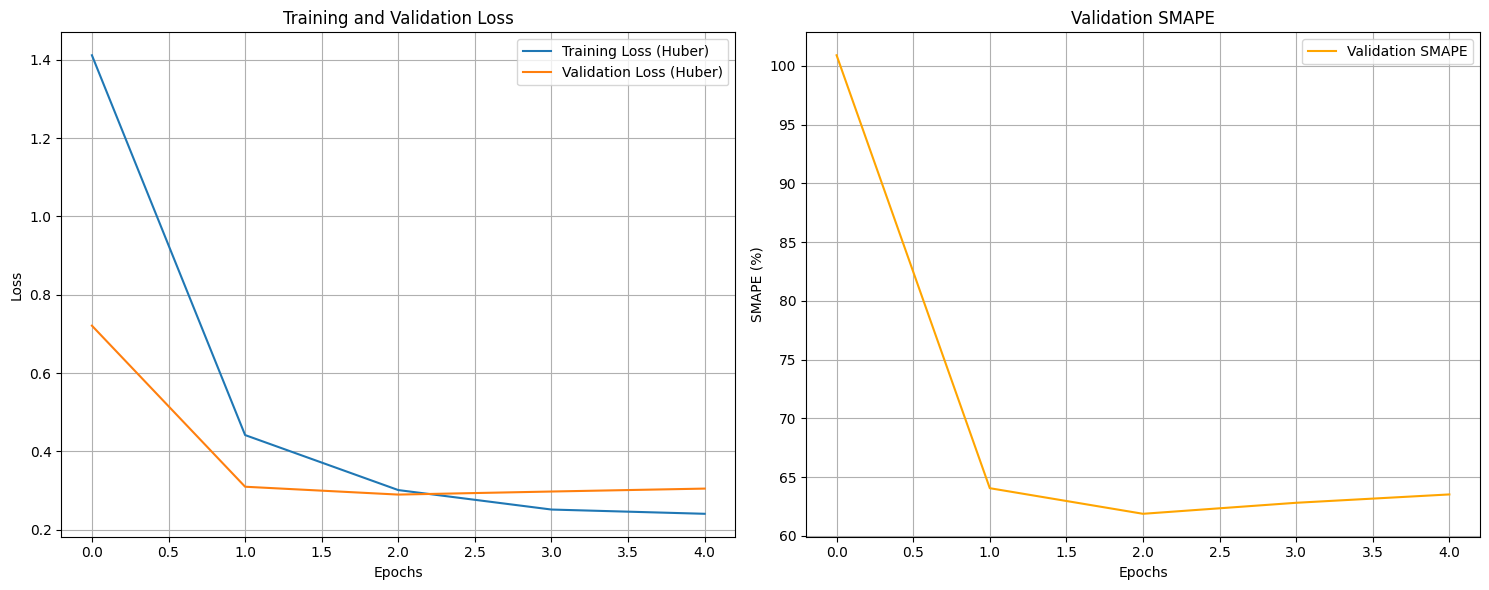

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import numpy as np
import open_clip
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

# --- 1. Setup and Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = 'ViT-B-32'
PRETRAINED_CHECKPOINT = 'laion2b_s34b_b79k'
BATCH_SIZE = 32
EPOCHS = 5 # Increased epochs for scheduler and early stopping
CLIP_LR = 1e-6
HEAD_LR = 1e-4
WEIGHT_DECAY = 0.01

print(f"Using device: {DEVICE}")

# --- 2. Load Your Data ---
# ⚠️ IMPORTANT: Load your actual DataFrame here
# df = pd.read_csv('path/to/your/data.csv')

# ⚠️ IMPORTANT: Set the path to your folder of downloaded images
IMAGE_DIR = 'output_folder' # Make sure this is your correct image folder path

if 'df' not in locals():
    print("DataFrame 'df' not found. Please load your data.")
    # You would exit or handle this error in a real script
    # For now, we'll assume it's loaded.

if not os.path.exists(IMAGE_DIR):
    raise FileNotFoundError(f"The specified image directory does not exist: {IMAGE_DIR}")

# --- 3. Data Preparation and Preprocessing ---

def create_comprehensive_description(row):
    parts = []
    if 'brand_name' in row and pd.notna(row.brand_name): parts.append(str(row.brand_name))
    if 'item_name' in row and pd.notna(row.item_name): parts.append(str(row.item_name))
    attributes = []
    if 'flavours_only' in row and pd.notna(row.flavours_only): attributes.append(str(row.flavours_only))
    if 'sizes_only' in row and pd.notna(row.sizes_only): attributes.append(str(row.sizes_only))
    if 'product_attributes' in row and pd.notna(row.product_attributes): attributes.append(str(row.product_attributes))
    if attributes: parts.append("Features: " + ", ".join(attributes) + ".")
    if 'product_benefits' in row and pd.notna(row.product_benefits): parts.append("Benefits: " + str(row.product_benefits))
    return " ".join(parts).replace("  ", " ").strip()

df['description'] = df.apply(create_comprehensive_description, axis=1)
df_processed = df[['sample_id', 'description', 'price', 'value', 'downloaded_image_name']].copy()
df_processed['image_path'] = df_processed['downloaded_image_name'].apply(lambda x: os.path.join(IMAGE_DIR, x))
df_processed.dropna(subset=['price', 'description', 'value'], inplace=True)
df_processed = df_processed[df_processed['description'] != '']

print("✅ Comprehensive text features created.")
train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)
print(f"Data split into {len(train_df)} training samples and {len(test_df)} testing samples.")


# --- 4. Dataset, Model, and Training Enhancements ---

class ProductPriceDataset(Dataset):
    def __init__(self, df, image_transform, tokenizer, value_stats):
        self.df = df
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.value_mean = value_stats['mean']
        self.value_std = value_stats['std']
        self.df['value_normalized'] = (df['value'] - self.value_mean) / self.value_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = self.image_transform(Image.open(row['image_path']).convert('RGB'))
        except FileNotFoundError:
            print(f"Warning: Image not found at {row['image_path']}. Skipping.")
            return None
        text = self.tokenizer(row['description'])[0]
        log_price = torch.log1p(torch.tensor(row['price'], dtype=torch.float32))
        numerical_feat = torch.tensor(row['value_normalized'], dtype=torch.float32)
        return {'image': image, 'text': text, 'numerical': numerical_feat, 'log_price': log_price}

# --- CORRECTED MODEL DEFINITION ---
class CLIPPricePredictor(nn.Module):
    def __init__(self, clip_model, numerical_feature_size=1):
        super().__init__()
        self.clip = clip_model
        clip_embedding_dim = self.clip.text_projection.shape[1]
        combined_dim = (clip_embedding_dim * 2) + numerical_feature_size
        self.regression_head = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1)
        )

    def forward(self, image, text, numerical_feats):
        image_features = self.clip.encode_image(image)
        text_features = self.clip.encode_text(text)
        
        # Perform standard division instead of inplace division
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        combined = torch.cat([image_features, text_features, numerical_feats.unsqueeze(1)], dim=1)
        return self.regression_head(combined).squeeze(-1)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience; self.min_delta = min_delta
        self.counter = 0; self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss; self.counter = 0
            print("✅ Validation loss decreased, saving model.")
            torch.save(model.state_dict(), 'best_model.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("🛑 Early stopping triggered!"); return True
        return False

def calculate_smape(preds, targets):
    numerator = torch.abs(preds - targets)
    denominator = (torch.abs(targets) + torch.abs(preds)) / 2
    return (torch.mean(numerator / (denominator + 1e-8)) * 100).item()

def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, loss_fn, epochs):
    history = {'train_loss': [], 'val_loss': [], 'val_smape': []}
    early_stopper = EarlyStopper(patience=5, min_delta=0.001)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
        for batch in progress_bar:
            if batch is None: continue
            images, texts = batch['image'].to(DEVICE), batch['text'].to(DEVICE)
            numerical = batch['numerical'].to(DEVICE)
            log_prices = batch['log_price'].to(DEVICE)

            optimizer.zero_grad()
            pred_log_prices = model(images, texts, numerical)
            loss = loss_fn(pred_log_prices, log_prices)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix({'log_huber_loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss, total_val_smape = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                if batch is None: continue
                images, texts = batch['image'].to(DEVICE), batch['text'].to(DEVICE)
                numerical = batch['numerical'].to(DEVICE)
                log_prices = batch['log_price'].to(DEVICE)

                pred_log_prices = model(images, texts, numerical)
                total_val_loss += loss_fn(pred_log_prices, log_prices).item()
                
                true_prices = torch.expm1(log_prices)
                pred_prices = torch.expm1(pred_log_prices)
                total_val_smape += calculate_smape(pred_prices, true_prices)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_smape = total_val_smape / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_smape'].append(avg_val_smape)
        print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val SMAPE: {avg_val_smape:.2f}%")
        
        scheduler.step()
        if early_stopper.early_stop(avg_val_loss, model): break
            
    model.load_state_dict(torch.load('best_model.pth'))
    return history, model

# --- Main Execution ---
if __name__ == '__main__':
    clip_model, _, base_preprocess = open_clip.create_model_and_transforms(
        MODEL_NAME, pretrained=PRETRAINED_CHECKPOINT, device=DEVICE
    )
    tokenizer = open_clip.get_tokenizer(MODEL_NAME)
    
    train_preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        base_preprocess,
    ])
    
    val_preprocess = base_preprocess
    value_stats = {'mean': train_df['value'].mean(), 'std': train_df['value'].std()}
    
    train_dataset = ProductPriceDataset(train_df, train_preprocess, tokenizer, value_stats)
    test_dataset = ProductPriceDataset(test_df, val_preprocess, tokenizer, value_stats)
    
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))
        return torch.utils.data.dataloader.default_collate(batch) if batch else None

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)
    
    model = CLIPPricePredictor(clip_model).to(DEVICE)
    
    optimizer = torch.optim.AdamW([
        {'params': model.clip.parameters(), 'lr': CLIP_LR},
        {'params': model.regression_head.parameters(), 'lr': HEAD_LR}
    ], weight_decay=WEIGHT_DECAY)
    
    loss_fn = nn.HuberLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

    training_history, best_model = train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, loss_fn, EPOCHS)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(training_history['train_loss'], label='Training Loss (Huber)')
    ax1.plot(training_history['val_loss'], label='Validation Loss (Huber)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(training_history['val_smape'], label='Validation SMAPE', color='orange')
    ax2.set_title('Validation SMAPE')
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('SMAPE (%)'); ax2.legend(); ax2.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# This code is for INFERENCE. Place it in a new script or a new cell.
# It requires the 'best_model.pth' file from the training script.

def predict_on_new_data(submission_df, train_df_for_stats, model_path='best_model.pth'):
    """
    Loads the trained model and predicts prices for a new dataframe.

    Args:
        submission_df (pd.DataFrame): DataFrame with product info (must include 'sample_id',
                                      'value', downloaded_image_name, and all text columns).
        train_df_for_stats (pd.DataFrame): The original training dataframe, needed to
                                           get the mean/std for normalization.
        model_path (str): Path to the saved best model weights.

    Returns:
        pd.DataFrame: A DataFrame with 'sample_id' and 'price' (predicted price).
    """
    print("🚀 Starting prediction process...")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, _, preprocess = open_clip.create_model_and_transforms(
        MODEL_NAME, pretrained=None, device=device # Pretrained weights are in our saved model
    )
    tokenizer = open_clip.get_tokenizer(MODEL_NAME)
    
    model = CLIPPricePredictor(clip_model).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    submission_df['description'] = submission_df.apply(create_comprehensive_description, axis=1)
    submission_df['image_path'] = submission_df['downloaded_image_name'].apply(
        lambda x: os.path.join(IMAGE_DIR, x) # Uses IMAGE_DIR defined globally
    )
    
    class InferenceDataset(Dataset):
        def __init__(self, df, image_transform, tokenizer, value_stats):
            self.df = df
            self.image_transform = image_transform
            self.tokenizer = tokenizer
            self.value_mean = value_stats['mean']
            self.value_std = value_stats['std']
            self.df['value_normalized'] = (df['value'] - self.value_mean) / self.value_std
            
        def __len__(self): return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            image = self.image_transform(Image.open(row['image_path']).convert('RGB'))
            text = self.tokenizer(row['description'])[0]
            numerical_feat = torch.tensor(row['value_normalized'], dtype=torch.float32)
            sample_id = row['sample_id']
            return {'image': image, 'text': text, 'numerical': numerical_feat, 'sample_id': sample_id}

    # IMPORTANT: Use the mean/std from the original training data
    value_stats = {'mean': train_df_for_stats['value'].mean(), 'std': train_df_for_stats['value'].std()}
    inference_dataset = InferenceDataset(submission_df, preprocess, tokenizer, value_stats)
    inference_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)
    
    all_preds, all_sample_ids = [], []
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Predicting"):
            images, texts, numerical = batch['image'].to(device), batch['text'].to(device), batch['numerical'].to(device)
            pred_log_prices = model(images, texts, numerical)
            pred_prices = torch.expm1(pred_log_prices)
            
            all_preds.extend(pred_prices.cpu().numpy())
            all_sample_ids.extend(batch['sample_id'].cpu().numpy())

    results_df = pd.DataFrame({'sample_id': all_sample_ids, 'price': all_preds})
    print("✅ Prediction complete.")
    return results_df

# --- Example Usage for Inference ---
# You need the original 'train_df' from your split to pass for normalization stats.
# The 'test_df' can simulate your submission data (we drop the 'price' column).

# submission_data = test_df.drop(columns=['price']).reset_index(drop=True)
# predictions = predict_on_new_data(submission_data, train_df_for_stats=train_df)
# print("\n--- Final Predictions ---")
# print(predictions.head())

In [9]:
# Install libraries for CLIP and data handling
# !pip install transformers torch numpy pandas Pillow scikit-learn tqdm

import os
import pandas as pd
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import shutil

# --- CONFIGURATION (ADJUST DRIVE PATHS ONCE) ---
# NOTE: The drive path below MUST match the path from your error message.
BASE_DRIVE_PATH = ''
DATASET_PATH = ''
DRIVE_IMAGE_DIR = ''

# --- OPTIMIZATION STEP: COPY DATA TO LOCAL DISK ---
LOCAL_IMAGE_DIR = 'final_check' # Use the fast, local Colab disk
if not os.path.exists(LOCAL_IMAGE_DIR):
    os.makedirs(LOCAL_IMAGE_DIR)

# Copy operation (This takes 5-15 minutes but prevents 5-hour training slowdown)
print(f"Copying images from slow Drive mount to fast local disk: {LOCAL_IMAGE_DIR}")
# Use rsync or shell command for potentially better performance on many files
!rsync -a --progress "$DRIVE_IMAGE_DIR" "$LOCAL_IMAGE_DIR"

# Update global path variables to use the LOCAL, fast disk
IMAGE_DIR = "output_folder"
CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
BATCH_SIZE = 64
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(RANDOM_SEED)
print(f"\nOptimization complete. Using device: {DEVICE}")


# --- 2. DATA LOADING AND SCALING ---

# Load the CSV log file
try:
    # Use the Drive path for the small CSV file, as reading the CSV is fast
    train_df = pd.read_csv(os.path.join(DATASET_PATH, 'Amazon_data - Sheet1.csv'))
except FileNotFoundError:
    print("FATAL ERROR: CSV log file not found. Cannot proceed.")
    raise

# Map image files to the NEW LOCAL PATH
train_df['image_file'] = train_df['downloaded_image_name'].apply(
    lambda x: os.path.join(IMAGE_DIR, x) if pd.notna(x) and x != 'NAN' and os.path.exists(os.path.join(IMAGE_DIR, x)) else None
)

# Filter out missing/corrupted files (those giving warnings in your previous run)
train_df = train_df.dropna(subset=['image_file']).reset_index(drop=True)
print(f"Total usable images for feature extraction: {len(train_df)}")

# Price Transformation: Log transform + MinMax Scaling
price_scaler = MinMaxScaler()
train_df['price_log'] = np.log1p(train_df['price']) 
train_df['price_scaled'] = price_scaler.fit_transform(train_df[['price_log']])


# --- 3. CUSTOM DATASET FOR CLIP (FIXED) ---

# --- 3. CUSTOM DATASET FOR CLIP (FIXED) ---

class ProductImageDataset(Dataset):
    # CORRECTED: Use double underscores for all special "dunder" methods
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.image_files = dataframe['image_file'].tolist()
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
            # Handle remaining file open errors by returning a black placeholder
            image = Image.new('RGB', (224, 224), 'black')

        # CRUCIAL: Processor handles resizing, normalization, and returns correct tensors
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze(0) # [1, C, H, W] -> [C, H, W]

        # Use .iloc to safely access the sample_id for the given index
        return pixel_values, self.dataframe['sample_id'].iloc[idx]

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_NAME)

# Custom collation function to stack tensors into a 4D batch
def collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch]) # Stacks to [B, C, H, W]
    sample_ids = [item[1] for item in batch]
    return pixel_values, sample_ids

image_dataloader = DataLoader(
    ProductImageDataset(train_df, clip_processor),
    batch_size=BATCH_SIZE,
    shuffle=False, # Maintain order for ID mapping
    num_workers=2, 
    collate_fn=collate_fn
)
print("CLIP setup and DataLoader ready. Proceed to extraction.")


# --- 4. FEATURE EXTRACTION AND SAVING ---

def extract_features(model, dataloader):
    """Feeds data through the model to extract features."""
    model.eval()
    all_embeddings = []
    all_sample_ids = []
    
    with torch.no_grad():
        for pixel_values, sample_ids in tqdm(dataloader, desc="Extracting CLIP Features"):
            pixel_values = pixel_values.to(DEVICE)
            
            # Use the model to encode the image (extract features)
            embeddings = model.get_image_features(pixel_values=pixel_values)
            
            all_embeddings.append(embeddings.cpu().numpy())
            all_sample_ids.extend(sample_ids)
            
    return np.concatenate(all_embeddings, axis=0), all_sample_ids

# Execute extraction (This should now be fast!)
image_embeddings, extracted_ids = extract_features(clip_model, image_dataloader)
print(f"Final shape of Image Embeddings: {image_embeddings.shape}")

# --- 5. CREATE AND SAVE FEATURE DATAFRAME (DELIVERABLE) ---

feature_dimension = image_embeddings.shape[1]
feature_names = [f'img_feat_{i}' for i in range(feature_dimension)]

feature_df = pd.DataFrame(image_embeddings, columns=feature_names)
feature_df.insert(0, 'sample_id', extracted_ids)

# Save the features to a CSV file on the mounted Drive (Persistence)
FEATURE_OUTPUT_PATH = os.path.join(DATASET_PATH, 'Amazon_data - Sheet1.csv')
feature_df.to_csv(FEATURE_OUTPUT_PATH, index=False)

print(f"\n✅ Image Feature Extraction Complete and saved to: {FEATURE_OUTPUT_PATH}")

Copying images from slow Drive mount to fast local disk: final_check


zsh:1: command not found: rsync

Optimization complete. Using device: cuda
Total usable images for feature extraction: 3978
CLIP setup and DataLoader ready. Proceed to extraction.


Extracting CLIP Features:   0%|          | 0/63 [00:00<?, ?it/s]

Final shape of Image Embeddings: (3978, 512)

✅ Image Feature Extraction Complete and saved to: Amazon_data - Sheet1.csv


In [20]:
df.shape

(3978, 14)

Using device: cuda
✅ Created comprehensive text features. Total samples: 3919
Data split into 3135 training and 784 testing samples.


Epoch 1/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/10 -> Train Loss: 1.4470 | Val Loss: 1.8627 | Val SMAPE: 181.61% | LR: 1.00e-06
✅ Validation loss decreased, saving model.


Epoch 2/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/10 -> Train Loss: 0.7021 | Val Loss: 0.6709 | Val SMAPE: 97.13% | LR: 9.76e-07
✅ Validation loss decreased, saving model.


Epoch 3/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/10 -> Train Loss: 0.3702 | Val Loss: 0.3478 | Val SMAPE: 68.13% | LR: 9.05e-07
✅ Validation loss decreased, saving model.


Epoch 4/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/10 -> Train Loss: 0.2866 | Val Loss: 0.3956 | Val SMAPE: 72.83% | LR: 7.96e-07


Epoch 5/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/10 -> Train Loss: 0.2583 | Val Loss: 0.3397 | Val SMAPE: 67.13% | LR: 6.58e-07
✅ Validation loss decreased, saving model.


Epoch 6/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/10 -> Train Loss: 0.2253 | Val Loss: 0.3278 | Val SMAPE: 66.04% | LR: 5.05e-07
✅ Validation loss decreased, saving model.


Epoch 7/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/10 -> Train Loss: 0.2107 | Val Loss: 0.3983 | Val SMAPE: 73.79% | LR: 3.52e-07


Epoch 8/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/10 -> Train Loss: 0.1997 | Val Loss: 0.3051 | Val SMAPE: 63.33% | LR: 2.14e-07
✅ Validation loss decreased, saving model.


Epoch 9/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/10 -> Train Loss: 0.1982 | Val Loss: 0.3090 | Val SMAPE: 63.79% | LR: 1.05e-07


Epoch 10/10 [Training]:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10/10 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/10 -> Train Loss: 0.1939 | Val Loss: 0.3348 | Val SMAPE: 66.72% | LR: 3.42e-08
Loading best model state from training.


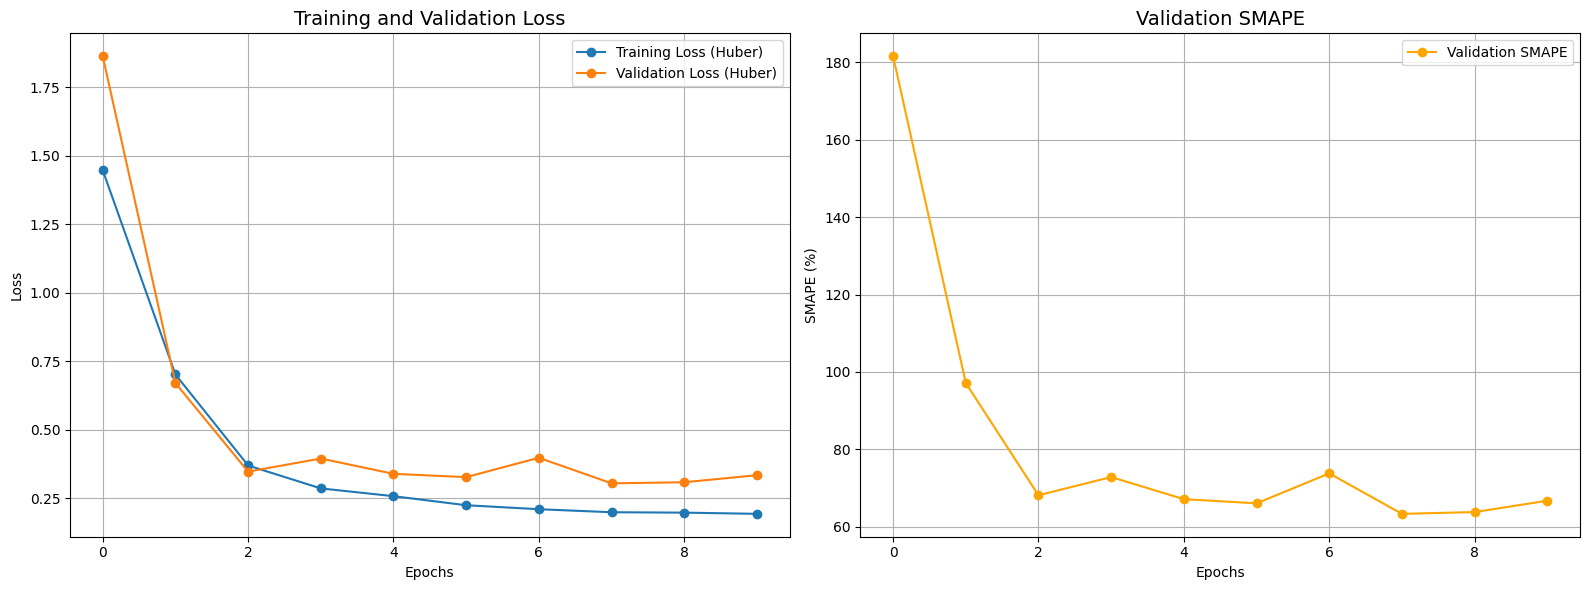

In [22]:
# --- 1. Import Libraries ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import numpy as np
import open_clip
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import warnings

# Suppress annoying but harmless warnings
warnings.filterwarnings("ignore", "Passing `palette` without `max_colors`")

# --- 2. Configuration & Setup ---
# A centralized place for all hyperparameters and settings
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    MODEL_NAME = 'ViT-B-32'
    PRETRAINED_CHECKPOINT = 'laion2b_s34b_b79k'
    BATCH_SIZE = 64  # Increased batch size if GPU memory allows
    EPOCHS = 10      # Increased for more robust training with early stopping
    
    # Differential Learning Rates are key for fine-tuning
    CLIP_LR = 1e-6
    HEAD_LR = 1e-4
    WEIGHT_DECAY = 0.01

    # Early Stopping parameters
    PATIENCE = 3
    MIN_DELTA = 0.001

    # Paths (⚠️ IMPORTANT: Update these paths)
    IMAGE_DIR = 'output_folder'
    # DF_PATH = 'path/to/your/data.csv' # Example

print(f"Using device: {Config.DEVICE}")

# --- 3. Data Loading and Preparation ---

# ⚠️ IMPORTANT: Load your actual DataFrame here
# For demonstration, we create a dummy DataFrame. Replace this with your pd.read_csv call.
# if 'df' not in locals():
#     print("DataFrame 'df' not found. Creating a dummy DataFrame for demonstration.")
#     data = {
#         'sample_id': range(1000),
#         'brand_name': [f'Brand{i%10}' for i in range(1000)],
#         'item_name': [f'Product {i}' for i in range(1000)],
#         'flavours_only': ['vanilla', 'chocolate', 'strawberry', 'mint'] * 250,
#         'sizes_only': ['100g', '250g', '500g', '1kg'] * 250,
#         'product_attributes': ['organic', 'gluten-free', None, 'sugar-free'] * 250,
#         'product_benefits': ['energy boost', 'muscle recovery', 'healthy snack', None] * 250,
#         'price': np.random.lognormal(mean=3, sigma=1, size=1000).tolist(),
#         'value': np.random.uniform(10, 100, size=1000).tolist(),
#         'downloaded_image_name': [f'dummy_image_{i}.png' for i in range(1000)]
#     }
#     df = pd.DataFrame(data)
#     # Create dummy images if they don't exist
#     if not os.path.exists(Config.IMAGE_DIR):
#         os.makedirs(Config.IMAGE_DIR)
#         for name in df['downloaded_image_name']:
#             dummy_img_path = os.path.join(Config.IMAGE_DIR, name)
#             if not os.path.exists(dummy_img_path):
#                 Image.new('RGB', (224, 224), 'gray').save(dummy_img_path)

# if not os.path.exists(Config.IMAGE_DIR):
#     raise FileNotFoundError(f"Image directory not found: {Config.IMAGE_DIR}")

def create_comprehensive_description(row):
    """Combines multiple text fields into a single rich description."""
    parts = []
    if pd.notna(row.get('brand_name')): parts.append(str(row['brand_name']))
    if pd.notna(row.get('item_name')): parts.append(str(row['item_name']))
    
    attributes = [str(row[col]) for col in ['flavours_only', 'sizes_only', 'product_attributes'] if col in row and pd.notna(row[col])]
    if attributes: parts.append(f"Features: {', '.join(attributes)}.")
    
    if pd.notna(row.get('product_benefits')): parts.append(f"Benefits: {row['product_benefits']}")
    
    return " ".join(parts).replace("  ", " ").strip()

# Apply feature engineering and preprocessing
df['description'] = df.apply(create_comprehensive_description, axis=1)
df_processed = df[['description', 'price', 'value', 'downloaded_image_name']].copy()
df_processed['image_path'] = df_processed['downloaded_image_name'].apply(lambda x: os.path.join(Config.IMAGE_DIR, str(x)))
df_processed.dropna(subset=['price', 'description', 'value'], inplace=True)
df_processed = df_processed[df_processed['description'] != '']

print(f"✅ Created comprehensive text features. Total samples: {len(df_processed)}")

train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)
print(f"Data split into {len(train_df)} training and {len(test_df)} testing samples.")

# --- 4. Dataset Class and DataLoaders ---

class ProductPriceDataset(Dataset):
    def __init__(self, df, image_transform, tokenizer, value_stats):
        self.df = df
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.value_mean = value_stats['mean']
        self.value_std = value_stats['std']
        # Pre-calculate normalized values for efficiency
        self.df['value_normalized'] = (self.df['value'] - self.value_mean) / self.value_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = self.image_transform(Image.open(row['image_path']).convert('RGB'))
        except (FileNotFoundError, UnboundLocalError):
            # Return None if image is missing, will be handled by collate_fn
            return None
        
        text = self.tokenizer(row['description'])[0]
        # Use log1p for numerical stability with prices near zero
        log_price = torch.tensor(np.log1p(row['price']), dtype=torch.float32)
        numerical_feat = torch.tensor(row['value_normalized'], dtype=torch.float32)
        
        return {'image': image, 'text': text, 'numerical': numerical_feat, 'log_price': log_price}

def collate_fn(batch):
    """Custom collate function to filter out None values from the batch."""
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if batch else None


# --- 5. Model, Training, and Evaluation ---

class CLIPPricePredictor(nn.Module):
    """The core model combining CLIP embeddings with numerical features."""
    def __init__(self, clip_model, numerical_feature_size=1, dropout_rate=0.4):
        super().__init__()
        self.clip = clip_model
        clip_embedding_dim = self.clip.text_projection.shape[1]
        combined_dim = (clip_embedding_dim * 2) + numerical_feature_size
        
        self.regression_head = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
        )

    def forward(self, image, text, numerical_feats):
        # Generate embeddings
        image_features = self.clip.encode_image(image)
        text_features = self.clip.encode_text(text)
        
        # L2 Normalize embeddings - a standard practice for CLIP
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Combine all features
        combined = torch.cat([image_features, text_features, numerical_feats.unsqueeze(1)], dim=1)
        
        return self.regression_head(combined).squeeze(-1)

class EarlyStopper:
    """Stops training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("✅ Validation loss decreased, saving model.")
            torch.save(model.state_dict(), 'best_model.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("🛑 Early stopping triggered!")
                return True
        return False

def calculate_smape(preds, targets):
    """Calculates Symmetric Mean Absolute Percentage Error."""
    numerator = torch.abs(preds - targets)
    denominator = (torch.abs(targets) + torch.abs(preds)) / 2
    # Add a small epsilon to avoid division by zero
    return (torch.mean(numerator / (denominator + 1e-8)) * 100).item()

def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, loss_fn, config):
    history = {'train_loss': [], 'val_loss': [], 'val_smape': []}
    early_stopper = EarlyStopper(patience=config.PATIENCE, min_delta=config.MIN_DELTA)

    for epoch in range(config.EPOCHS):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS} [Training]")
        
        for batch in progress_bar:
            if batch is None: continue # Skip faulty batches
            
            images = batch['image'].to(config.DEVICE)
            texts = batch['text'].to(config.DEVICE)
            numerical = batch['numerical'].to(config.DEVICE)
            log_prices = batch['log_price'].to(config.DEVICE)

            optimizer.zero_grad()
            pred_log_prices = model(images, texts, numerical)
            loss = loss_fn(pred_log_prices, log_prices)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix({'log_huber_loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss, total_val_smape = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS} [Validation]"):
                if batch is None: continue
                
                images = batch['image'].to(config.DEVICE)
                texts = batch['text'].to(config.DEVICE)
                numerical = batch['numerical'].to(config.DEVICE)
                log_prices = batch['log_price'].to(config.DEVICE)

                pred_log_prices = model(images, texts, numerical)
                total_val_loss += loss_fn(pred_log_prices, log_prices).item()
                
                # Convert back from log scale to calculate SMAPE on actual prices
                true_prices = torch.expm1(log_prices)
                pred_prices = torch.expm1(pred_log_prices)
                total_val_smape += calculate_smape(pred_prices, true_prices)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_smape = total_val_smape / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_smape'].append(avg_val_smape)
        
        print(f"Epoch {epoch+1}/{config.EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val SMAPE: {avg_val_smape:.2f}% | LR: {scheduler.get_last_lr()[0]:.2e}")
        
        scheduler.step()
        if early_stopper.early_stop(avg_val_loss, model):
            break
            
    # Load the best performing model before returning
    print("Loading best model state from training.")
    model.load_state_dict(torch.load('best_model.pth'))
    return history, model


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    # Initialize CLIP model, tokenizer, and image transformations
    clip_model, _, base_preprocess = open_clip.create_model_and_transforms(
        Config.MODEL_NAME, pretrained=Config.PRETRAINED_CHECKPOINT, device=Config.DEVICE
    )
    tokenizer = open_clip.get_tokenizer(Config.MODEL_NAME)
    
    # Add data augmentation for the training set to improve model generalization
    train_preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        base_preprocess,
    ])
    
    # Calculate normalization stats ONLY from the training data to avoid data leakage
    value_stats = {'mean': train_df['value'].mean(), 'std': train_df['value'].std()}
    
    train_dataset = ProductPriceDataset(train_df, train_preprocess, tokenizer, value_stats)
    test_dataset = ProductPriceDataset(test_df, base_preprocess, tokenizer, value_stats)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
    
    model = CLIPPricePredictor(clip_model).to(Config.DEVICE)
    
    # Set up optimizer with differential learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.clip.parameters(), 'lr': Config.CLIP_LR},
        {'params': model.regression_head.parameters(), 'lr': Config.HEAD_LR}
    ], weight_decay=Config.WEIGHT_DECAY)
    
    # HuberLoss is robust to outliers, which is common in price data
    loss_fn = nn.HuberLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS, eta_min=1e-8)

    # Run the training and evaluation loop
    training_history, best_model = train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, loss_fn, Config)

    # --- 7. Plotting Results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs_ran = len(training_history['train_loss'])
    
    ax1.plot(range(epochs_ran), training_history['train_loss'], label='Training Loss (Huber)', marker='o')
    ax1.plot(range(epochs_ran), training_history['val_loss'], label='Validation Loss (Huber)', marker='o')
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    
    ax2.plot(range(epochs_ran), training_history['val_smape'], label='Validation SMAPE', color='orange', marker='o')
    ax2.set_title('Validation SMAPE', fontsize=14)
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('SMAPE (%)'); ax2.legend(); ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

#final code 

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("FullData_train_with_image_name.xlsx - train_with_image_name.csv")

In [6]:
df.shape

(75000, 13)

In [7]:
df = df.head(4000)

In [16]:
df.shape

(4000, 41)

In [17]:
# Add this line right after you load your 'df'
df.columns = df.columns.str.strip()

Using device: cuda
Available columns in your DataFrame: ['sample_id', 'catalog_content', 'brand_name', 'descriptions', 'benefits', 'values', 'pack_of', 'item_name', 'pack_of.1', 'image_link', 'price', 'downloaded_image_name', 'description', 'unit_COUNT', 'unit_Count', 'unit_Each', 'unit_FL Oz', 'unit_Fl Oz', 'unit_Fl. Oz', 'unit_Fluid Ounce', 'unit_Jar', 'unit_Liters', 'unit_OZ', 'unit_Ounce', 'unit_Ounces', 'unit_Oz', 'unit_Pound', 'unit_bottle', 'unit_count', 'unit_ct', 'unit_fl oz', 'unit_gram', 'unit_gramm', 'unit_grams', 'unit_lb', 'unit_millilitre', 'unit_ounce', 'unit_ounces', 'unit_oz', 'unit_pound', 'unit_unknown']
Cleaned column names: ['sample_id', 'catalog_content', 'brand_name', 'descriptions', 'benefits', 'values', 'pack_of', 'item_name', 'pack_of.1', 'image_link', 'price', 'downloaded_image_name', 'description', 'unit_COUNT', 'unit_Count', 'unit_Each', 'unit_FL Oz', 'unit_Fl Oz', 'unit_Fl. Oz', 'unit_Fluid Ounce', 'unit_Jar', 'unit_Liters', 'unit_OZ', 'unit_Ounce', 'unit

Epoch 1/5 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/5 -> Train Loss: 1.4444 | Val Loss: 1.7815 | Val SMAPE: 176.04% | LR: 1.00e-06
✅ Validation loss decreased, saving model.


Epoch 2/5 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/5 -> Train Loss: 0.7340 | Val Loss: 0.7773 | Val SMAPE: 107.20% | LR: 9.05e-07
✅ Validation loss decreased, saving model.


Epoch 3/5 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/5 -> Train Loss: 0.4455 | Val Loss: 0.5870 | Val SMAPE: 90.41% | LR: 6.58e-07
✅ Validation loss decreased, saving model.


Epoch 4/5 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/5 -> Train Loss: 0.3681 | Val Loss: 0.3626 | Val SMAPE: 68.44% | LR: 3.52e-07
✅ Validation loss decreased, saving model.


Epoch 5/5 [Training]:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/5 -> Train Loss: 0.3490 | Val Loss: 0.3169 | Val SMAPE: 63.68% | LR: 1.05e-07
✅ Validation loss decreased, saving model.
Loading best model state from training.


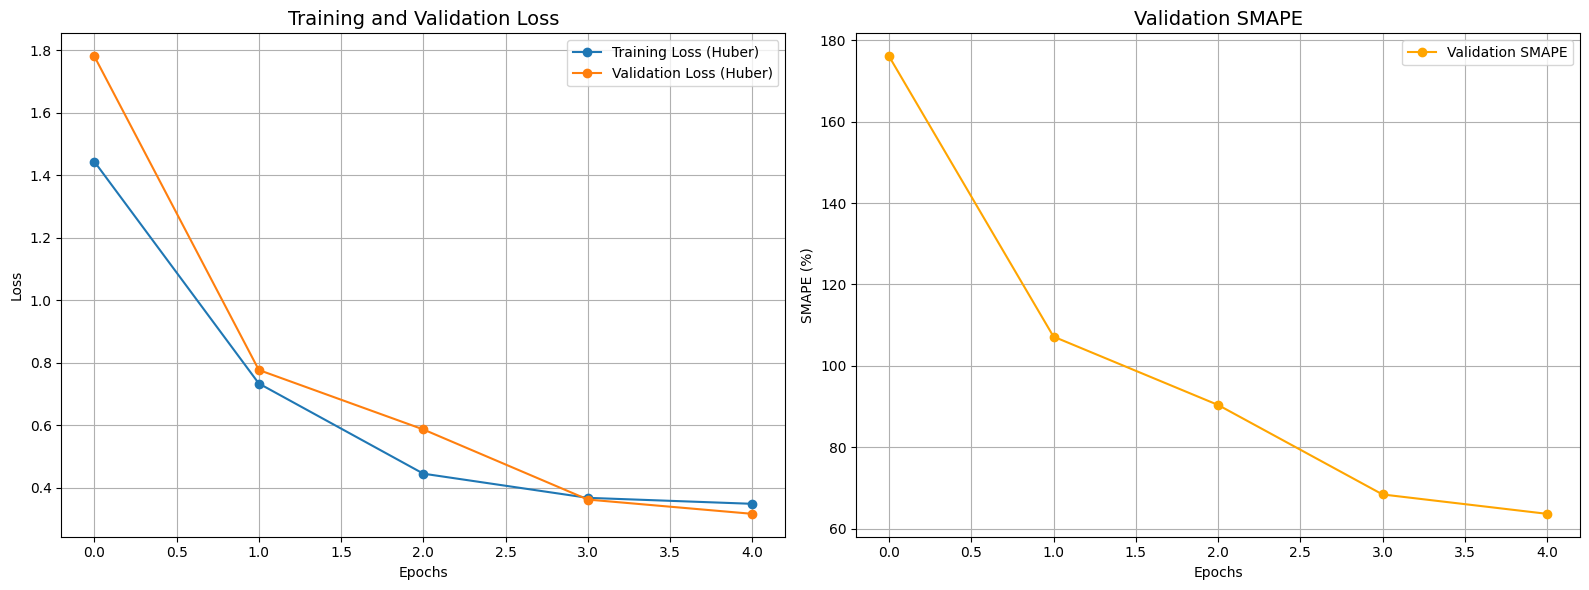

In [20]:
# --- 1. Import Libraries ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import numpy as np
import open_clip
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import warnings

# Suppress annoying but harmless warnings
warnings.filterwarnings("ignore", "Passing `palette` without `max_colors`")

# --- 2. Configuration & Setup ---
class Config:
    """A centralized class for all hyperparameters and settings."""
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    MODEL_NAME = 'ViT-B-32'
    PRETRAINED_CHECKPOINT = 'laion2b_s34b_b79k'
    BATCH_SIZE = 64
    EPOCHS = 5

    # Differential Learning Rates for fine-tuning
    CLIP_LR = 1e-6
    HEAD_LR = 1e-4
    WEIGHT_DECAY = 0.01

    # Early Stopping parameters
    PATIENCE = 3
    MIN_DELTA = 0.001

    # Paths (⚠️ IMPORTANT: Update this path if needed)
    IMAGE_DIR = 'output_folder'

print(f"Using device: {Config.DEVICE}")
if not os.path.exists(Config.IMAGE_DIR):
    raise FileNotFoundError(f"Image directory not found: {Config.IMAGE_DIR}. Please check the path.")

# --- 3. Data Loading and Enhanced Feature Engineering ---

# ⚠️ ===================================================================
# ⚠️ IMPORTANT: Load your actual DataFrame 'df' here.
# ⚠️ Example: df = pd.read_csv('path/to/your/data.csv')
# ⚠️ ===================================================================
# This block is a placeholder. Ensure your 'df' is loaded before this script runs.
# For demonstration purposes, I will create a dummy DataFrame.
# In your environment, you should already have 'df' loaded from your file.
if 'df' not in locals():
     raise NameError("DataFrame 'df' is not defined. Please load your data where indicated.")

# Add this line to see all your available column names
print(f"Available columns in your DataFrame: {df.columns.tolist()}")


def create_comprehensive_description(row):
    """Combines multiple text fields into a single rich description for CLIP."""
    parts = []
    # Add brand, item name, and general description for richer context
    if pd.notna(row.get('brand_name')): parts.append(str(row['brand_name']))
    if pd.notna(row.get('item_name')): parts.append(str(row['item_name']))
    if pd.notna(row.get('descriptions')): parts.append(f"Description: {row['descriptions']}")

    # This part is kept for generality, it won't find columns in your current df but won't error
    attributes = [str(row[col]) for col in ['flavours_only', 'sizes_only', 'product_attributes'] if col in row and pd.notna(row[col])]
    if attributes: parts.append(f"Features: {', '.join(attributes)}.")

    if pd.notna(row.get('benefits')): parts.append(f"Benefits: {row['benefits']}")

    return " ".join(parts).replace("  ", " ").strip()

# --- Preprocessing for Numerical and Categorical Features ---
# --- Preprocessing for Numerical and Categorical Features ---

# ✅ FIX: Strip leading/trailing whitespace from all column names
df.columns = df.columns.str.strip()

# Optional: Print the cleaned column names to verify
print("Cleaned column names:", df.columns.tolist())

# ✅ MODIFIED: Convert 'values' from object to a numeric type.
# 'coerce' will turn any non-numeric values (like text) into NaN (Not a Number).
df['values'] = pd.to_numeric(df['values'], errors='coerce')

# Handle missing values before splitting.
# For 'pack_of', assume NaN means a single item.
# Handle missing values before splitting.
df['pack_of'] = df['pack_of'].fillna(1.0).astype(float)

# --- Idempotent 'units' processing ---
# This check ensures this block only runs if the 'units' column exists.
if 'units' in df.columns:
    print("Processing 'units' column (one-hot encoding)...")
    # For 'units', fill NaN with 'unknown' to create a separate category.
    df['units'] = df['units'].fillna('unknown').astype(str)
    # This line removes the 'units' column and replaces it with one-hot encoded columns.
    df = pd.get_dummies(df, columns=['units'], prefix='unit', dtype=float)
else:
    print("'units' column already processed. Skipping one-hot encoding.")
    
# Apply text feature engineering
df['description'] = df.apply(create_comprehensive_description, axis=1)

# ... the rest of your code follows

# ✅ MODIFIED #1: Replaced 'YOUR_VALUE_COLUMN_NAME' with 'values' from your DataFrame.
VALUE_COL = 'values'
if VALUE_COL not in df.columns:
    raise KeyError(f"Column '{VALUE_COL}' not found in DataFrame. Please check the column name.")


# Define columns to be used
unit_cols = [col for col in df.columns if col.startswith('unit_')]
numerical_cols = [VALUE_COL, 'pack_of'] + unit_cols # This now correctly includes 'values'
feature_cols = ['description', 'price', 'downloaded_image_name'] + numerical_cols

df_processed = df[feature_cols].copy()
df_processed['image_path'] = df_processed['downloaded_image_name'].apply(lambda x: os.path.join(Config.IMAGE_DIR, str(x)))

# ✅ MODIFIED #2: This line now correctly uses the 'values' column via the VALUE_COL variable.
# It also drops rows where 'values' became NaN after the numeric conversion.
df_processed.dropna(subset=['price', 'description', VALUE_COL], inplace=True)
df_processed = df_processed[df_processed['description'] != '']

print(f"✅ Created features. Total samples: {len(df_processed)}. Numerical/Categorical features: {numerical_cols}")

train_df, test_df = train_test_split(df_processed, test_size=0.2, random_state=42)
print(f"Data split into {len(train_df)} training and {len(test_df)} testing samples.")


# --- 4. Dataset Class and DataLoaders ---

class ProductPriceDataset(Dataset):
    """Custom PyTorch Dataset for loading product images, text, and numerical features."""
    def __init__(self, df, image_transform, tokenizer, numerical_cols, stats):
        self.df = df.copy() # Use a copy to avoid SettingWithCopyWarning
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.numerical_cols = numerical_cols
        self.stats = stats
        self.value_col_name = numerical_cols[0] # Assumes the value column ('values') is the first one

        # Pre-calculate normalized values for efficiency
        for col in [self.value_col_name, 'pack_of']:
            mean = self.stats[col]['mean']
            std = self.stats[col]['std']
            self.df[f'{col}_normalized'] = (self.df[col] - mean) / (std + 1e-6)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = self.image_transform(Image.open(row['image_path']).convert('RGB'))
        except (FileNotFoundError, UnboundLocalError, OSError):
            # Return None if image is missing or corrupt, will be handled by collate_fn
            return None

        text = self.tokenizer(row['description'])[0]
        log_price = torch.tensor(np.log1p(row['price']), dtype=torch.float32)

        # Create a single tensor for all numerical features
        # ✅ MODIFIED #3: This now correctly gets the normalized 'values' column.
        norm_value = torch.tensor(row[f'{self.value_col_name}_normalized'], dtype=torch.float32)
        norm_pack_of = torch.tensor(row['pack_of_normalized'], dtype=torch.float32)
        unit_features = torch.tensor(row[[c for c in self.numerical_cols if c.startswith('unit_')]].values.astype(np.float32))
        numerical_feats = torch.cat([norm_value.unsqueeze(0), norm_pack_of.unsqueeze(0), unit_features])

        return {'image': image, 'text': text, 'numerical': numerical_feats, 'log_price': log_price}

def collate_fn(batch):
    """Custom collate function to filter out None values from the batch."""
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if batch else None


# --- 5. Model, Training, and Evaluation ---

class CLIPPricePredictor(nn.Module):
    """The core model combining CLIP embeddings with numerical features."""
    def __init__(self, clip_model, numerical_feature_size, dropout_rate=0.4):
        super().__init__()
        self.clip = clip_model
        clip_embedding_dim = self.clip.text_projection.shape[1]
        # The combined dimension now includes the size of our numerical feature vector
        combined_dim = (clip_embedding_dim * 2) + numerical_feature_size

        self.regression_head = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)
        )

    def forward(self, image, text, numerical_feats):
        # Generate embeddings
        with torch.no_grad(): # Freeze CLIP encoder during training head
            image_features = self.clip.encode_image(image)
            text_features = self.clip.encode_text(text)

        # L2 Normalize embeddings - a standard practice for CLIP
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Concatenate image, text, and the multi-dimensional numerical features
        combined = torch.cat([image_features, text_features, numerical_feats], dim=1)

        return self.regression_head(combined).squeeze(-1)

class EarlyStopper:
    """Stops training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            print("✅ Validation loss decreased, saving model.")
            torch.save(model.state_dict(), 'best_model.pth')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                print("🛑 Early stopping triggered!")
                return True
        return False

def calculate_smape(preds, targets):
    """Calculates Symmetric Mean Absolute Percentage Error."""
    numerator = torch.abs(preds - targets)
    denominator = (torch.abs(targets) + torch.abs(preds)) / 2
    # Add a small epsilon to avoid division by zero
    return (torch.mean(numerator / (denominator + 1e-8)) * 100).item()

def train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, loss_fn, config):
    """The main training and validation loop."""
    history = {'train_loss': [], 'val_loss': [], 'val_smape': []}
    early_stopper = EarlyStopper(patience=config.PATIENCE, min_delta=config.MIN_DELTA)

    for epoch in range(config.EPOCHS):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS} [Training]")

        for batch in progress_bar:
            if batch is None: continue # Skip faulty batches

            images = batch['image'].to(config.DEVICE)
            texts = batch['text'].to(config.DEVICE)
            numerical = batch['numerical'].to(config.DEVICE)
            log_prices = batch['log_price'].to(config.DEVICE)

            optimizer.zero_grad()
            pred_log_prices = model(images, texts, numerical)
            loss = loss_fn(pred_log_prices, log_prices)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix({'log_huber_loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss, total_val_smape = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS} [Validation]"):
                if batch is None: continue

                images = batch['image'].to(config.DEVICE)
                texts = batch['text'].to(config.DEVICE)
                numerical = batch['numerical'].to(config.DEVICE)
                log_prices = batch['log_price'].to(config.DEVICE)

                pred_log_prices = model(images, texts, numerical)
                total_val_loss += loss_fn(pred_log_prices, log_prices).item()

                # Convert back from log scale to calculate SMAPE on actual prices
                true_prices = torch.expm1(log_prices)
                pred_prices = torch.expm1(pred_log_prices)
                total_val_smape += calculate_smape(pred_prices, true_prices)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_smape = total_val_smape / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_smape'].append(avg_val_smape)

        print(f"Epoch {epoch+1}/{config.EPOCHS} -> Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val SMAPE: {avg_val_smape:.2f}% | LR: {scheduler.get_last_lr()[0]:.2e}")

        scheduler.step()
        if early_stopper.early_stop(avg_val_loss, model):
            break

    print("Loading best model state from training.")
    model.load_state_dict(torch.load('best_model.pth'))
    return history, model


# --- 6. Main Execution Block ---
if __name__ == '__main__':
    # Initialize CLIP model, tokenizer, and image transformations
    clip_model, _, base_preprocess = open_clip.create_model_and_transforms(
        Config.MODEL_NAME, pretrained=Config.PRETRAINED_CHECKPOINT, device=Config.DEVICE
    )
    tokenizer = open_clip.get_tokenizer(Config.MODEL_NAME)

    # Add data augmentation for the training set to improve model generalization
    train_preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        base_preprocess,
    ])

    # Calculate normalization stats ONLY from the training data to avoid data leakage
    # ✅ MODIFIED #4: This now correctly creates a dictionary key 'values' for the stats.
    stats = {
        VALUE_COL: {'mean': train_df[VALUE_COL].mean(), 'std': train_df[VALUE_COL].std()},
        'pack_of': {'mean': train_df['pack_of'].mean(), 'std': train_df['pack_of'].std()}
    }

    train_dataset = ProductPriceDataset(train_df, train_preprocess, tokenizer, numerical_cols, stats)
    test_dataset = ProductPriceDataset(test_df, base_preprocess, tokenizer, numerical_cols, stats)

    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

    # Pass the correct number of numerical features to the model
    NUMERICAL_FEATURE_SIZE = len(numerical_cols)
    model = CLIPPricePredictor(clip_model, numerical_feature_size=NUMERICAL_FEATURE_SIZE).to(Config.DEVICE)
    
    # Freeze the CLIP model parameters initially
    for param in model.clip.parameters():
        param.requires_grad = False

    # Set up optimizer with differential learning rates
    optimizer = torch.optim.AdamW([
        {'params': model.clip.parameters(), 'lr': Config.CLIP_LR},
        {'params': model.regression_head.parameters(), 'lr': Config.HEAD_LR}
    ], weight_decay=Config.WEIGHT_DECAY)

    # HuberLoss is robust to outliers, which is common in price data
    loss_fn = nn.HuberLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=Config.EPOCHS, eta_min=1e-8)

    # Run the training and evaluation loop
    training_history, best_model = train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler, loss_fn, Config)

    # --- 7. Plotting Results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs_ran = len(training_history['train_loss'])

    ax1.plot(range(epochs_ran), training_history['train_loss'], label='Training Loss (Huber)', marker='o')
    ax1.plot(range(epochs_ran), training_history['val_loss'], label='Validation Loss (Huber)', marker='o')
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    ax2.plot(range(epochs_ran), training_history['val_smape'], label='Validation SMAPE', color='orange', marker='o')
    ax2.set_title('Validation SMAPE', fontsize=14)
    ax2.set_xlabel('Epochs'); ax2.set_ylabel('SMAPE (%)'); ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample_id              4000 non-null   int64  
 1   catalog_content        4000 non-null   object 
 2   brand_name             3733 non-null   object 
 3   descriptions           1700 non-null   object 
 4   benefits               3193 non-null   object 
 5   values                 3941 non-null   float64
 6   pack_of                4000 non-null   float64
 7   item_name              4000 non-null   object 
 8   pack_of.1              1397 non-null   float64
 9   image_link             4000 non-null   object 
 10  price                  4000 non-null   float64
 11  downloaded_image_name  4000 non-null   object 
 12  description            4000 non-null   object 
 13  unit_COUNT             4000 non-null   float64
 14  unit_Count             4000 non-null   float64
 15  unit